In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import pyplot, patches
import plotly.express as px
import numpy as np
import pandas as pd
from library import tools, evals, architectures
from evaluation import deep_features_plot
import os
import pathlib
import torch
from torch.nn import functional as F
import sklearn

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Functions

In [8]:
def get_fpr_tpr(test_probs, test_gt, classes, thresholds):
    # vary thresholds
    tpr, fpr, thrs = [], [], []
    for c in classes:
        c_tpr, c_fpr = [], []
        t_probs, f_probs = test_probs[test_gt == c,c], test_probs[test_gt != c,c]
        # print(t_probs.shape, f_probs.shape)
        # true_mask = test_gt == c
        for tau in thresholds:
            # true positive rate
            c_tpr.append(np.sum(t_probs >= tau) / len(t_probs))
            # false positive rete
            c_fpr.append(np.sum(f_probs >= tau) / len(f_probs))
        tpr.append(c_tpr)
        fpr.append(c_fpr)
        thrs.append(thresholds)
        
    return fpr, tpr, thrs


In [9]:
def recall_oscr_results(which='MultiBinary', arch='LeNet_plus_plus', dataset='SmallScale'):
    root_path = f'/home/user/hkim/UZH-MT/openset-binary/_results/{dataset}/eval_{arch}/{which}/oscr'
    print(root_path, which)
    oscr_results = [
        np.load(os.path.join(root_path,'ccr.npy')),
        np.load(os.path.join(root_path,'fpr_neg.npy')),
        np.load(os.path.join(root_path,'fpr_unkn.npy')),
        ]
    return oscr_results

In [10]:
def recall_pred_results(which='MultiBinary', arch='LeNet_plus_plus', dataset='SmallScale'):
    root_path = f'/home/user/hkim/UZH-MT/openset-binary/_results/{dataset}/eval_{arch}'
    print(root_path, which)
    pred_results = {}
    if dataset == 'SmallScale':
        pred_results['train'] = [np.load(os.path.join(root_path, which, 'pred', 'train_gt.npy')), np.load(os.path.join(root_path, which, 'pred', 'train_logits.npy')), np.load(os.path.join(root_path, which, 'pred', 'train_feats.npy')), np.load(os.path.join(root_path, which, 'pred', 'train_probs.npy'))]
        pred_results['test_neg'] = [np.load(os.path.join(root_path, which, 'pred', 'test_neg_gt.npy')), np.load(os.path.join(root_path, which, 'pred', 'test_neg_logits.npy')), np.load(os.path.join(root_path, which, 'pred', 'test_neg_feats.npy')), np.load(os.path.join(root_path, which, 'pred', 'test_neg_probs.npy'))]
        pred_results['test_unkn'] = [np.load(os.path.join(root_path, which, 'pred', 'test_unkn_gt.npy')), np.load(os.path.join(root_path, which, 'pred', 'test_unkn_logits.npy')), np.load(os.path.join(root_path, which, 'pred', 'test_unkn_feats.npy')), np.load(os.path.join(root_path, which, 'pred', 'test_unkn_probs.npy'))]
    else:
        pred_results['test_neg'] = [np.load(os.path.join(root_path, which, 'pred', 'test_neg_gt.npy')), np.load(os.path.join(root_path, which, 'pred', 'test_neg_logits.npy')), None, np.load(os.path.join(root_path, which, 'pred', 'test_neg_probs.npy'))]
        pred_results['test_unkn'] = [np.load(os.path.join(root_path, which, 'pred', 'test_unkn_gt.npy')), np.load(os.path.join(root_path, which, 'pred', 'test_unkn_logits.npy')), None, np.load(os.path.join(root_path, which, 'pred', 'test_unkn_probs.npy'))]        
    return pred_results

In [11]:
def get_net(which):
    model_root='/home/user/hkim/UZH-MT/openset-binary/_models'
    network_file = os.path.join(model_root, f"SmallScale/LeNet_plus_plus/{which}/{which}.model")

    if which == 'Garbage':
        num_classes = 11
    else:
        num_classes = 10

    net = architectures.__dict__["LeNet_plus_plus"](small_scale=True,
                                                    use_BG=False,
                                                    num_classes=num_classes)
    net.load_state_dict(torch.load(network_file, map_location=torch.device('cpu')))
    return net

In [12]:
def plot_multiple_linear_functions(param_list):
    """
    Plots multiple linear functions ax + by = 1 given a list of coefficient pairs [[a1, b1], [a2, b2], ...].

    Args:
        coefficients_list (list of lists): List of coefficient pairs [[a1, b1], [a2, b2], ...].
    """
    pyplot.figure(figsize=(8, 6))
    x_values = np.linspace(-10000, 10000, 100)

    for i, coefficients in enumerate(param_list):
        a, b = coefficients
        slope = -a / b
        intercept = 1 / b
        y_values = slope * x_values + intercept
        pyplot.plot(x_values, y_values, label=f"{i}", color = pyplot.cm.tab10(i))

    pyplot.xlabel('x')
    pyplot.ylabel('y')
    pyplot.axhline(0, color='gray', linestyle='--', linewidth=0.5)
    pyplot.axvline(0, color='gray', linestyle='--', linewidth=0.5)
    pyplot.grid(True)
    pyplot.legend()


In [7]:
def get_stats(gt, logits, label):
    pos = gt == label
    unkn = gt == -1
    neg = ~(pos | unkn)
    
    print(f"Total: {len(gt)} \t gt=={label}: {sum(pos)} \t unkn: {sum(unkn)} \t neg: {sum(neg)}")

    pos_logits = logits[pos,label]
    unkn_logits = logits[unkn,label]
    neg_logits = logits[neg,label]

    print(f"pos_logit_min_max: {np.min(pos_logits):.2f}~{np.max(pos_logits):.2f}")
    print(f"unkn_logit_min_max: {np.min(unkn_logits):.2f}~{np.max(unkn_logits):.2f}")
    print(f"neg_logit_min_max: {np.min(neg_logits):.2f}~{np.max(neg_logits):.2f}")

    return pos_logits, unkn_logits, neg_logits

# Logit Distribution

In [8]:
which = 'MultiBinary'
dataset = 'SmallScale'
arch = 'LeNet_plus_plus_focal'
# LeNet_plus_plus
# LeNet_plus_plus_moon_global       LeNet_plus_plus_moon_batch
# LeNet_plus_plus_focal

unkn_gt_label = -1

pred_results = recall_pred_results(which, arch, dataset)

# gt, logits, feats, probs = pred_results['train']
# gt, logits, feats, probs = pred_results['test_neg']
gt, logits, feats, probs = pred_results['test_unkn']

/home/user/hkim/UZH-MT/openset-binary/_results/SmallScale/eval_LeNet_plus_plus_focal MultiBinary


Total: 18800 	 gt==0: 1000 	 unkn: 8800 	 neg: 9000
pos_logit_min_max: -47.43~2.85
unkn_logit_min_max: -1616.78~2.81
neg_logit_min_max: -2068.35~0.14


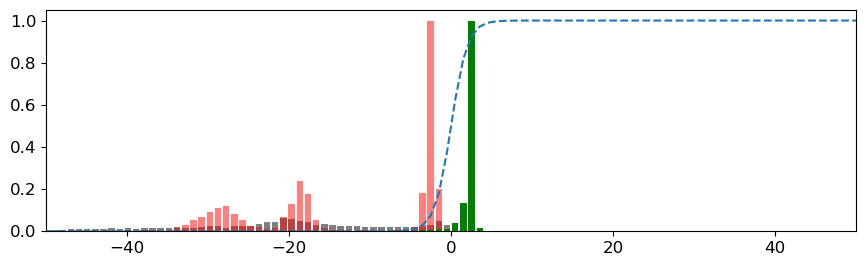

Total: 18800 	 gt==1: 1000 	 unkn: 8800 	 neg: 9000
pos_logit_min_max: -40.98~2.48
unkn_logit_min_max: -1750.00~1.57
neg_logit_min_max: -2387.07~0.07


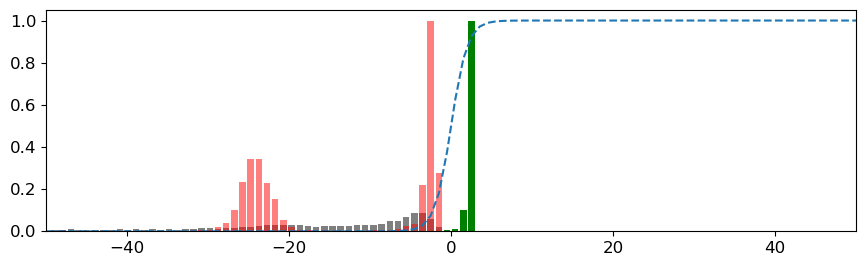

Total: 18800 	 gt==2: 1000 	 unkn: 8800 	 neg: 9000
pos_logit_min_max: -12.32~4.58
unkn_logit_min_max: -230.28~4.02
neg_logit_min_max: -332.81~-0.20


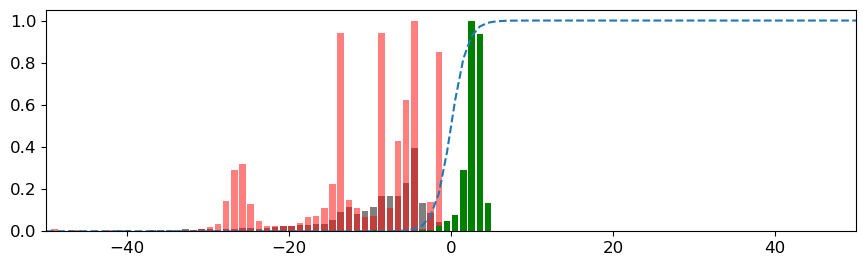

Total: 18800 	 gt==3: 1000 	 unkn: 8800 	 neg: 9000
pos_logit_min_max: -265.39~4.42
unkn_logit_min_max: -450.87~2.28
neg_logit_min_max: -674.40~2.61


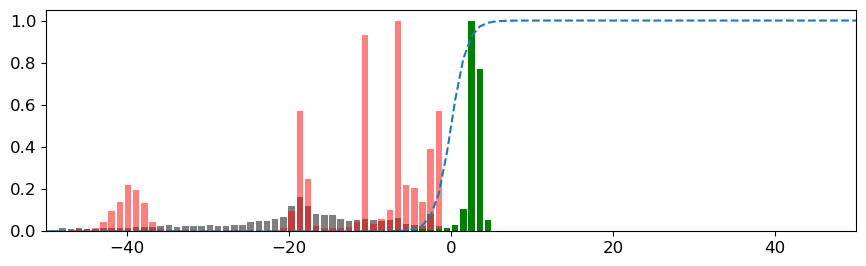

Total: 18800 	 gt==4: 1000 	 unkn: 8800 	 neg: 9000
pos_logit_min_max: -396.32~3.67
unkn_logit_min_max: -3146.85~3.69
neg_logit_min_max: -4445.16~-0.22


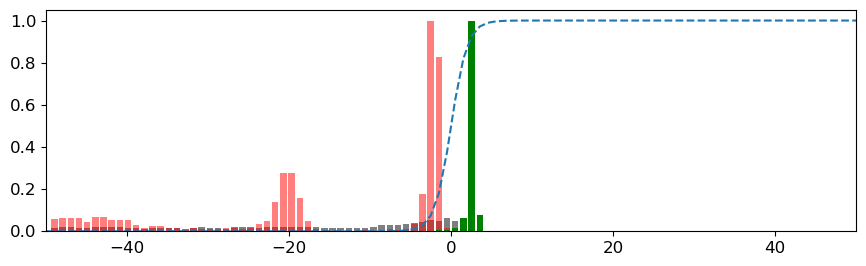

Total: 18800 	 gt==5: 1000 	 unkn: 8800 	 neg: 9000
pos_logit_min_max: -5.04~14.48
unkn_logit_min_max: -5.67~8.35
neg_logit_min_max: -5.68~-1.14


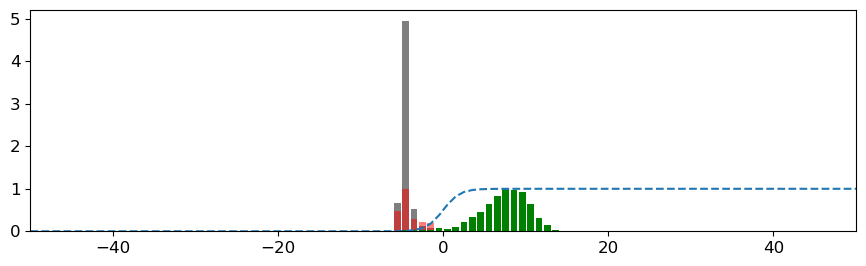

Total: 18800 	 gt==6: 1000 	 unkn: 8800 	 neg: 9000
pos_logit_min_max: -6.57~5.52
unkn_logit_min_max: -75.33~2.12
neg_logit_min_max: -108.39~-0.36


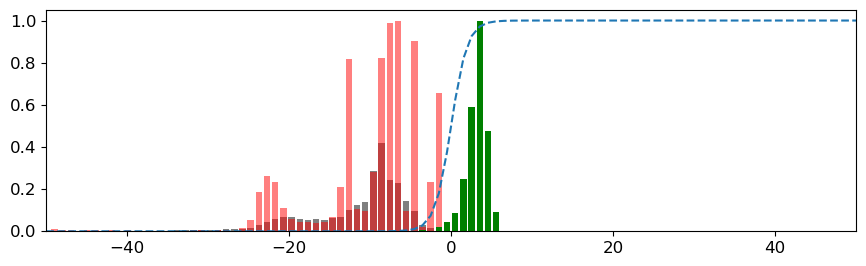

Total: 18800 	 gt==7: 1000 	 unkn: 8800 	 neg: 9000
pos_logit_min_max: -67.42~5.49
unkn_logit_min_max: -2917.73~3.68
neg_logit_min_max: -4166.24~0.51


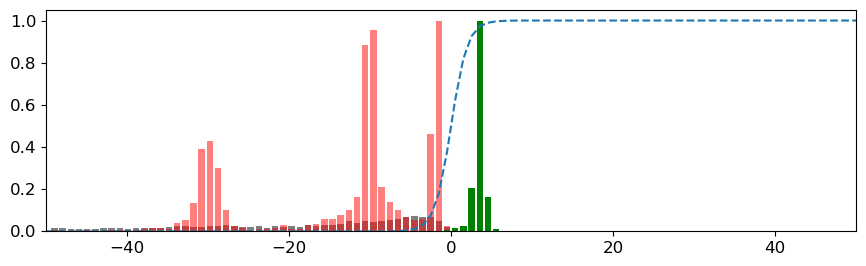

Total: 18800 	 gt==8: 1000 	 unkn: 8800 	 neg: 9000
pos_logit_min_max: -5.37~11.95
unkn_logit_min_max: -10.67~6.49
neg_logit_min_max: -13.64~1.79


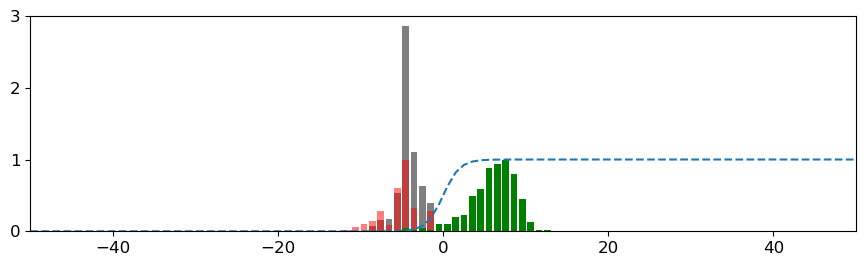

Total: 18800 	 gt==9: 1000 	 unkn: 8800 	 neg: 9000
pos_logit_min_max: -230.58~3.55
unkn_logit_min_max: -1414.98~4.88
neg_logit_min_max: -2050.81~2.87


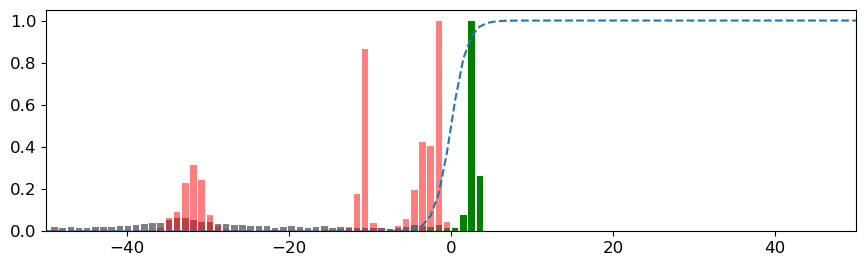

In [9]:
for i in range(10):
    label = i
    pos_logits, unkn_logits, neg_logits = get_stats(gt, logits, label)
    xrange = (-50,50)
    bins = np.linspace(xrange[0],xrange[1],100)
    pos_hist = np.histogram(pos_logits, bins=bins, density=True)
    unkn_hist = np.histogram(unkn_logits, bins=bins, density=True,)
    neg_hist = np.histogram(neg_logits, bins=bins, density=True,)

    fig, ax = pyplot.subplots(figsize=(9, 3))
    ax.bar(
        unkn_hist[1][1:],
        unkn_hist[0].astype(np.float16) / max(pos_hist[0]),
        label='unkn',
        color="black",
        alpha=0.5
    )
    ax.bar(
        neg_hist[1][1:],
        neg_hist[0].astype(np.float16) / max(neg_hist[0]),
        color="r",
        label='neg',
        alpha=0.5
    )
    ax.bar(
        pos_hist[1][1:],
        pos_hist[0].astype(np.float16) / max(pos_hist[0]),
        label=label,
        color="g",
        alpha=1
    )

    ax.plot(bins, 1/(1+np.exp(-bins)), linestyle='--')

    ax.tick_params(axis="both", which="major", labelsize=12)

    pyplot.xlim(xrange[0],xrange[1])
    pyplot.tight_layout()
    pyplot.savefig(f'{i}_logit.png')
    pyplot.show()

# Binary Classifier Deep Feature Space

In [12]:
which = 'MultiBinary'
dataset = 'SmallScale'
arch = 'LeNet_plus_plus_focal'
# LeNet_plus_plus
# LeNet_plus_plus_moon_global       LeNet_plus_plus_moon_batch
# LeNet_plus_plus_focal

unkn_gt_label = -1

pred_results = recall_pred_results(which, arch, dataset)

/home/user/hkim/UZH-MT/openset-binary/_results/SmallScale/eval_LeNet_plus_plus_focal MultiBinary


In [15]:
df = pd.DataFrame(data = {'x': pred_results['train'][2][:,0], 'y': pred_results['train'][2][:,1], 'label':pred_results['train'][0]})
df = df.loc[df['label'] != -1]
df["label"] = df["label"].astype(str)

fig = px.scatter(df, x="x", y="y", color="label", color_discrete_sequence=px.colors.qualitative.D3,
                 category_orders={'label': np.sort(df['label'].unique())},
                 labels=['label'], width=500, height=500)

# Case. Bias = False
# fig.update_xaxes(range=[-1000, 14000], title=None)
# fig.update_yaxes(range=[-2000,1000], title=None)

# Case. Bias = True
fig.update_xaxes(range=[-100, 1000], title=None)
fig.update_yaxes(range=[-1000,100], title=None)

fig.update_layout(
    margin=dict(l=5, r=5, t=5, b=5),
)

fig.show()

# Confusion Matrix

In [23]:
which = 'Garbage'   # SoftMax   Garbage    EOS    MultiBinary
dataset = 'LargeScale_3'  # SmallScale   LargeScale   LargeScale_2    LargeScale_3
arch = 'ResNet_18'
# LeNet_plus_plus       LeNet_plus_plus_moon_global     LeNet_plus_plus_moon_batch       LeNet_plus_plus_focal
# ResNet_18     ResNet_18_moon_global       ResNet_18_moon_batch        ResNet_18_focal

unkn_gt_label_info = {
    'SmallScale': 10,
    'LargeScale': 116, 'LargeScale_2': 30, 'LargeScale_3': 151
}

if which != 'Garbage':
    unkn_gt_label = -1     # -1 10 116 30 151
else:
    unkn_gt_label = unkn_gt_label_info[dataset]

pred_results = recall_pred_results(which, arch, dataset)
print(np.unique(pred_results['test_unkn'][0]))
print(np.unique(np.argmax(pred_results['test_unkn'][3], axis=1)))

/home/user/hkim/UZH-MT/openset-binary/_results/LargeScale_3/eval_ResNet_18 Garbage
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  7

## Train Set

[ 0  1  2  3  4  5  6  7  8  9 10] [ 0  1  2  3  4  5  6  7  8  9 10]


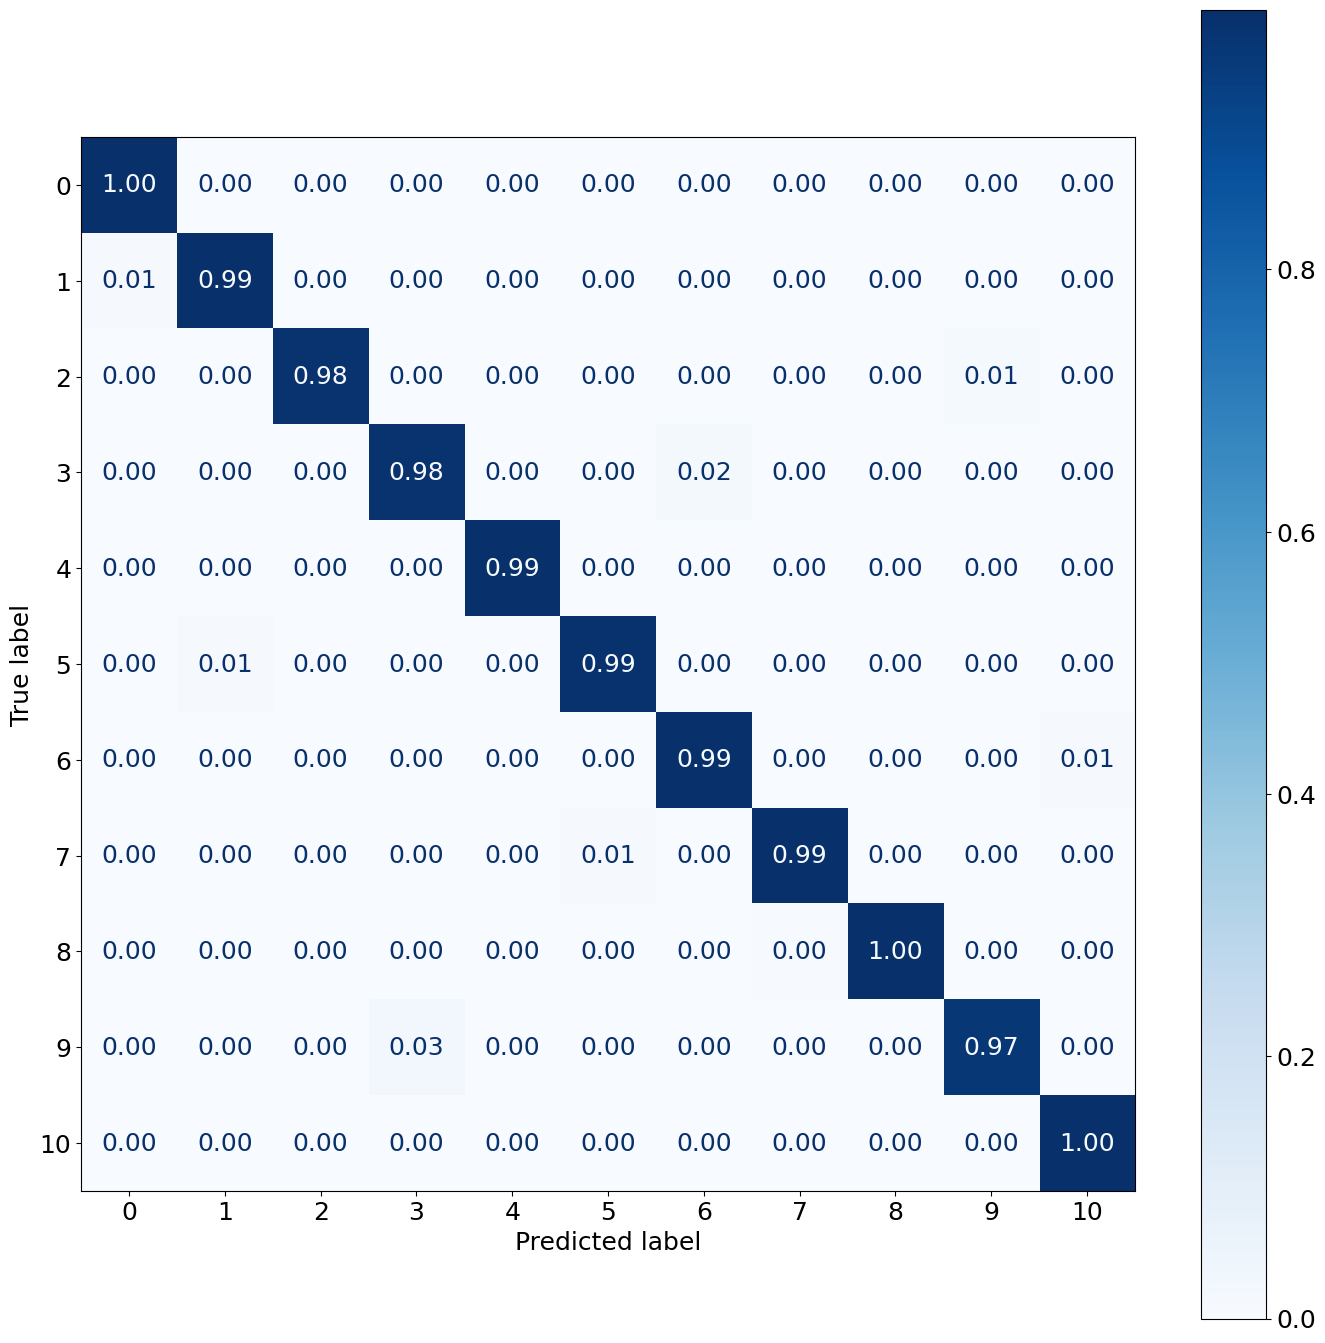

In [15]:
df = pd.DataFrame(data = {'gt': pred_results['train'][0], 'pred': np.argmax(pred_results['train'][3], axis=1)})
if which != 'Garbage':
    df = df.loc[df['gt'] != unkn_gt_label]
print(np.unique(df['gt']), np.unique(df['pred']))
fig, ax = pyplot.subplots(figsize=(17,17))

include_values = False
if dataset == 'SmallScale':
    include_values = True

ConfusionMatrixDisplay.from_predictions(df['gt'], df['pred'],
                                        normalize='true', values_format='.2f',
                                        include_values=include_values, 
                                        cmap=pyplot.cm.Blues, ax=ax)
pyplot.show()


## Test Set

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151] [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93 

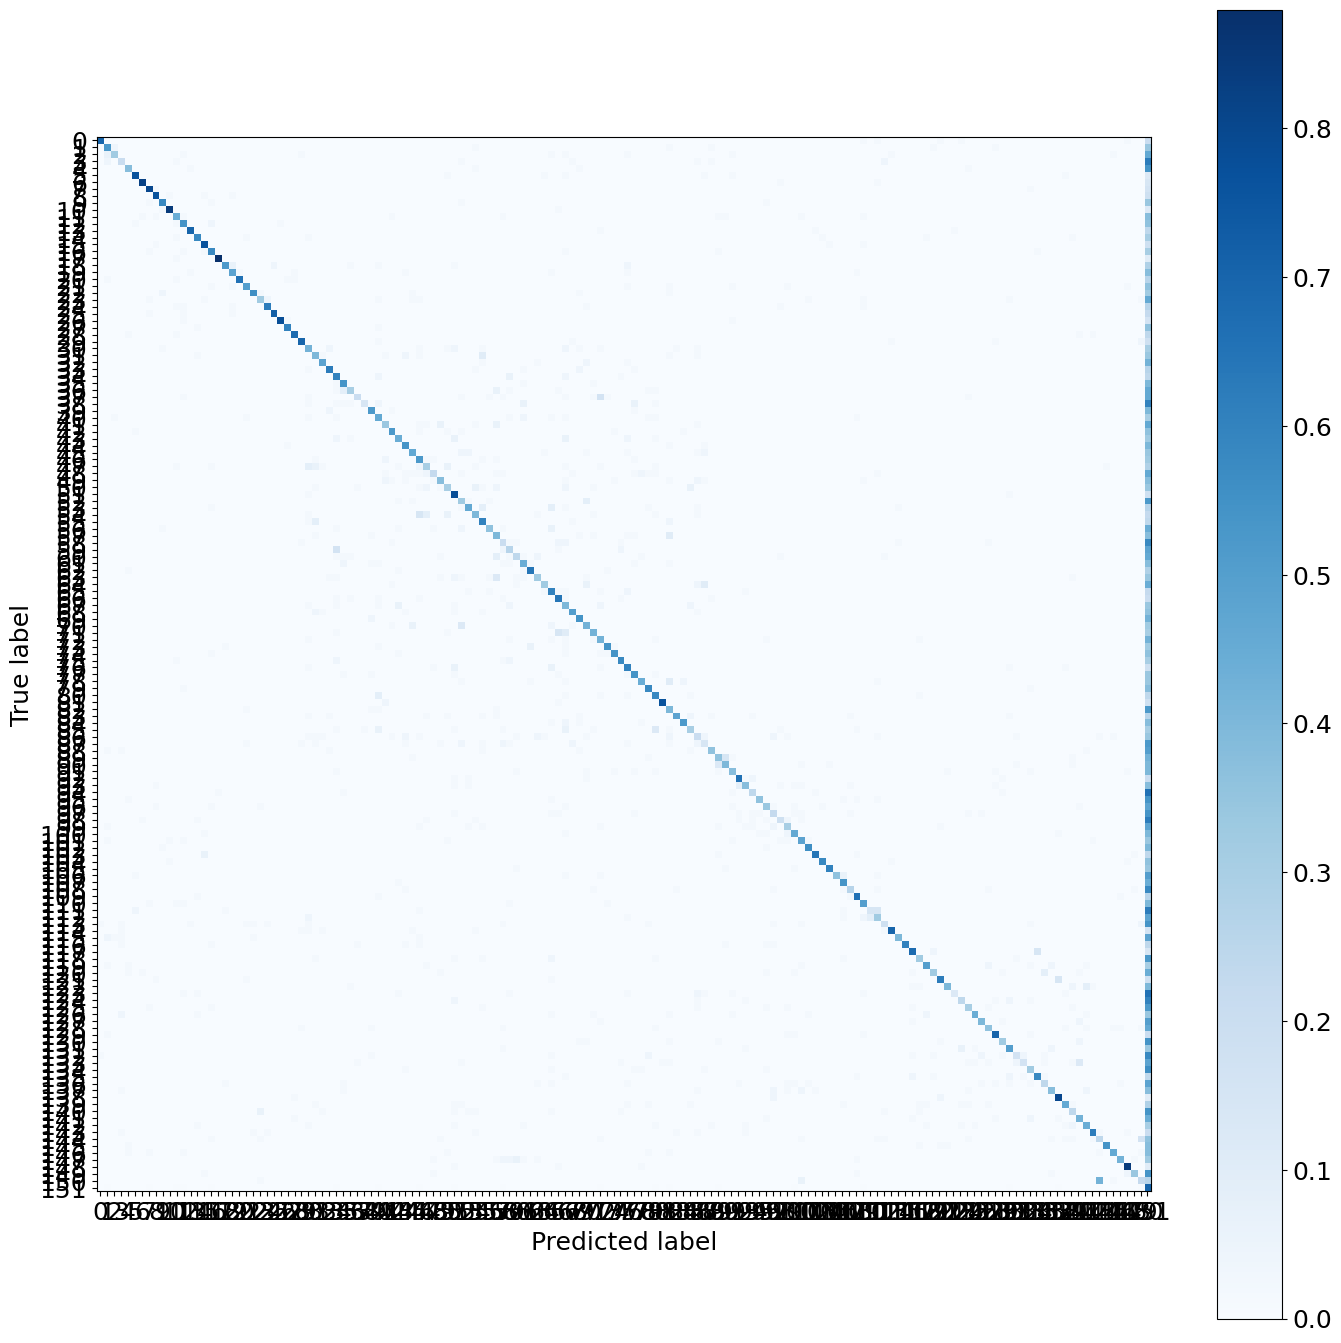

In [24]:
df = pd.DataFrame(data = {'gt': pred_results['test_unkn'][0], 'pred': np.argmax(pred_results['test_unkn'][3], axis=1)})
if which != 'Garbage':
    df = df.loc[df['gt'] != unkn_gt_label]
print(np.unique(df['gt']), np.unique(df['pred']))

fig, ax = pyplot.subplots(figsize=(17,17))

include_values = False
if dataset == 'SmallScale':
    include_values = True

ConfusionMatrixDisplay.from_predictions(df['gt'], df['pred'],
                                        normalize='true', values_format='.2f',
                                        include_values=include_values, 
                                        cmap=pyplot.cm.Blues, ax=ax)
pyplot.show()

# OSCR Curve

In [19]:
# [
#       SmallScale   LargeScale   LargeScale_2    LargeScale_3 ,
#
#       LeNet_plus_plus       LeNet_plus_plus_moon_global     LeNet_plus_plus_moon_batch    LeNet_plus_plus_focal   LeNet_plus_plus_mining
#       ResNet_18     ResNet_18_moon_global       ResNet_18_moon_batch      ResNet_18_focal     ResNet_18_mining
#
#       SoftMax   Garbage    EOS    MultiBinary ,
# ]

oscr_plots = [
    # {'info':['SmallScale','LeNet_plus_plus','SoftMax'],'label':'Plain SoftMax','alpha':0.1},
    # {'info':['SmallScale','LeNet_plus_plus','Garbage'],'label':'Garbage Class','alpha':0.1},
    # {'info':['SmallScale','LeNet_plus_plus','EOS'],'label':'Entropic Open-Set','alpha':0.1},
    {'info':['LargeScale_3','ResNet_18','MultiBinary'],'label':'Multiple Binary Classifiers','alpha':1},

    # ------------------------------------------------------------------------------
    {'info':['LargeScale_3','ResNet_18_moon_global','MultiBinary'],'label':'+ MOON (Global)','alpha':1},
    {'info':['LargeScale_3','ResNet_18_moon_batch','MultiBinary'],'label':'+ MOON (Batch)','alpha':1},
    # {'info':['SmallScale','LeNet_plus_plus_moon_batch_2','MultiBinary'],'label':'+ MOON (Batch,2)','alpha':1},
    # {'info':['SmallScale','LeNet_plus_plus_moon_batch_3','MultiBinary'],'label':'+ MOON (Batch,3)','alpha':1},
    # {'info':['SmallScale','LeNet_plus_plus_moon_batch_4','MultiBinary'],'label':'+ MOON (Batch,4)','alpha':1},
    # {'info':['SmallScale','LeNet_plus_plus_moon_batch_5','MultiBinary'],'label':'+ MOON (Batch,5)','alpha':1},
    # {'info':['SmallScale','LeNet_plus_plus_moon_batch_5_lin','MultiBinary'],'label':'+ MOON (Batch,5,lin)','alpha':1},
    # {'info':['SmallScale','LeNet_plus_plus_moon_batch_5_conc','MultiBinary'],'label':'+ MOON (Batch,5,concave)','alpha':1},
    # {'info':['SmallScale','LeNet_plus_plus_moon_batch_5_conv','MultiBinary'],'label':'+ MOON (Batch,5,convex)','alpha':1},
    # {'info':['SmallScale','LeNet_plus_plus_moon_batch_5_comp','MultiBinary'],'label':'+ MOON (Batch,5,composite)','alpha':1},

    # ------------------------------------------------------------------------------
    # {'info':['SmallScale','LeNet_plus_plus_mining_2','MultiBinary'],'label':'+ mining (2)','alpha':1},
    # {'info':['SmallScale','LeNet_plus_plus_mining_4','MultiBinary'],'label':'+ mining (4)','alpha':1},
    # {'info':['SmallScale','LeNet_plus_plus_mining_8','MultiBinary'],'label':'+ mining (8)','alpha':1},
    # {'info':['SmallScale','LeNet_plus_plus_mining_16','MultiBinary'],'label':'+ mining (16)','alpha':1},
    # {'info':['SmallScale','LeNet_plus_plus_mining_32','MultiBinary'],'label':'+ mining (32)','alpha':1},
    # {'info':['SmallScale','LeNet_plus_plus_mining_64','MultiBinary'],'label':'+ mining (64)','alpha':1},
    # {'info':['SmallScale','LeNet_plus_plus_mining_0','MultiBinary'],'label':'+ mining (0)','alpha':1},
    # {'info':['SmallScale','LeNet_plus_plus_mining_1e-1','MultiBinary'],'label':'+ mining (0.1)','alpha':1},
    # {'info':['SmallScale','LeNet_plus_plus_mining_3e-1','MultiBinary'],'label':'+ mining (0.3)','alpha':1},
    # {'info':['SmallScale','LeNet_plus_plus_mining_5e-1_global','MultiBinary'],'label':'+ mining (global 0.5)','alpha':1},
    # {'info':['SmallScale','LeNet_plus_plus_mining_5e-1','MultiBinary'],'label':'+ mining (0.5)','alpha':1},
    # {'info':['SmallScale','LeNet_plus_plus_mining_7e-1','MultiBinary'],'label':'+ mining (0.7)','alpha':1},
    # {'info':['SmallScale','LeNet_plus_plus_mining_9e-1','MultiBinary'],'label':'+ mining (0.9)','alpha':1},
    # {'info':['SmallScale','LeNet_plus_plus_mining_lin','MultiBinary'],'label':'+ mining (lin)','alpha':1},
    # {'info':['SmallScale','LeNet_plus_plus_mining_conc','MultiBinary'],'label':'+ mining (concave)','alpha':1},
    # {'info':['SmallScale','LeNet_plus_plus_mining_conv','MultiBinary'],'label':'+ mining (convex)','alpha':1},
    # {'info':['SmallScale','LeNet_plus_plus_mining_comp','MultiBinary'],'label':'+ mining (composite)','alpha':1},

    # ------------------------------------------------------------------------------
    # {'info':['SmallScale','LeNet_plus_plus_focal','MultiBinary'],'label':'+ Focal Loss','alpha':1},
]

In [20]:
results = []

for item in oscr_plots:
    info = item['info']
    oscr_results = recall_oscr_results(which=info[2], arch=info[1], dataset=info[0])
    results.append(oscr_results)

/home/user/hkim/UZH-MT/openset-binary/_results/LargeScale_3/eval_ResNet_18/MultiBinary/oscr MultiBinary
/home/user/hkim/UZH-MT/openset-binary/_results/LargeScale_3/eval_ResNet_18_moon_global/MultiBinary/oscr MultiBinary
/home/user/hkim/UZH-MT/openset-binary/_results/LargeScale_3/eval_ResNet_18_moon_batch/MultiBinary/oscr MultiBinary


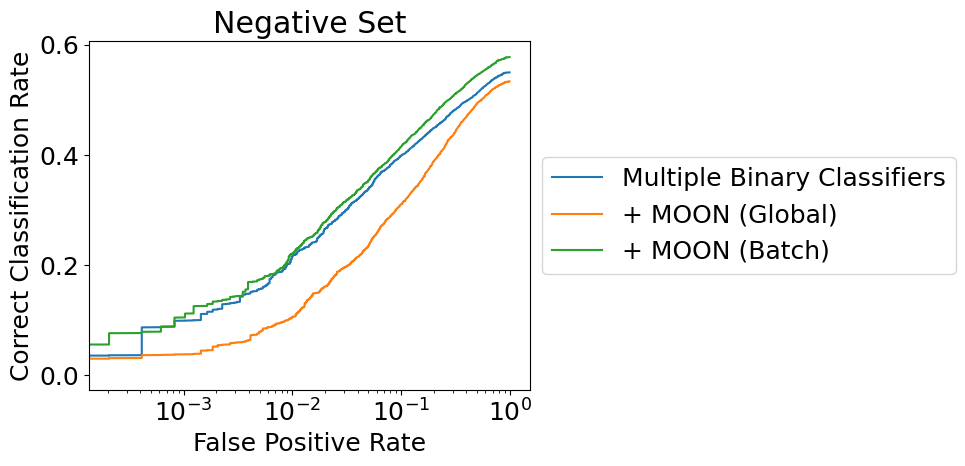

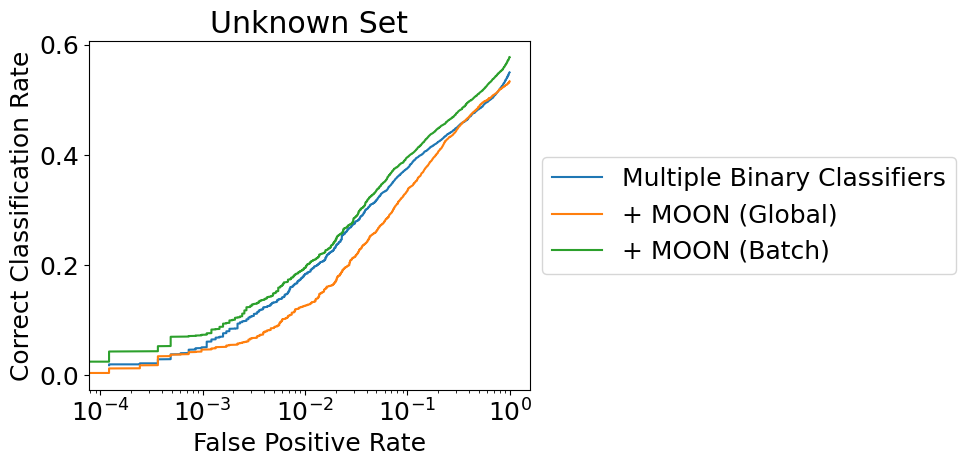

In [21]:
# plot with known unknowns
pyplot.figure(figsize=(10,5))
for idx, res in enumerate(results):
    pyplot.semilogx(res[1], res[0], label=oscr_plots[idx]['label'], alpha=oscr_plots[idx]['alpha'])
pyplot.legend(loc='center left', bbox_to_anchor=(1, 0.5))
pyplot.xlabel("False Positive Rate")
pyplot.ylabel("Correct Classification Rate")
pyplot.title("Negative Set")
pyplot.tight_layout()
# pyplot.savefig(root.joinpath('oscr_neg.png'), bbox_inches="tight") 

# plot with unknown unknowns
pyplot.figure(figsize=(10,5))
for idx, res in enumerate(results):
    pyplot.semilogx(res[2], res[0], label=oscr_plots[idx]['label'], alpha=oscr_plots[idx]['alpha'])
pyplot.legend(loc='center left', bbox_to_anchor=(1, 0.5))
pyplot.xlabel("False Positive Rate")
pyplot.ylabel("Correct Classification Rate")
pyplot.title("Unknown Set")
pyplot.tight_layout()
# pyplot.savefig(root.joinpath('oscr_unkn.png'), bbox_inches="tight") 

# MBC - FPR and CCR by Threshold

In [34]:
data_infos = [
    {'info':['SmallScale','LeNet_plus_plus','MultiBinary'],'label':'MBC: Multiple Binary Classifiers','alpha':0.8, 'linestyle': '-', 'color':pyplot.cm.tab10(0)},
    {'info':['SmallScale','LeNet_plus_plus_moon_global','MultiBinary'],'label':'+ MOON (Global)','alpha':0.8, 'linestyle': '-.', 'color':pyplot.cm.tab10(1)},
    {'info':['SmallScale','LeNet_plus_plus_moon_batch','MultiBinary'],'label':'+ MOON (Batch)','alpha':0.8, 'linestyle': '-', 'color':pyplot.cm.tab10(1)},
    {'info':['SmallScale','LeNet_plus_plus_focal','MultiBinary'],'label':'+ Focal Loss','alpha':0.8, 'linestyle': '-', 'color':pyplot.cm.tab10(2)},
    {'info':['SmallScale','LeNet_plus_plus_mining_64','MultiBinary'],'label':'+ Mining(64)','alpha':0.8, 'linestyle': '-', 'color':pyplot.cm.tab10(3)},
]

unkn_gt_label = -1
num_of_classes = 10
classes = np.arange(0,num_of_classes)
thresholds = np.linspace(0.1,0.9,9)
print(thresholds)

for info in data_infos:
    pred_results = recall_pred_results(info['info'][2], info['info'][1], info['info'][0])
    gt, logits, feats, probs = pred_results['test_unkn']
    fpr, tpr, thrs = get_fpr_tpr(probs, gt, classes, thresholds)
    info['result'] = [fpr, tpr, thrs]


[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
/home/user/hkim/UZH-MT/openset-binary/_results/SmallScale/eval_LeNet_plus_plus MultiBinary
/home/user/hkim/UZH-MT/openset-binary/_results/SmallScale/eval_LeNet_plus_plus_moon_global MultiBinary
/home/user/hkim/UZH-MT/openset-binary/_results/SmallScale/eval_LeNet_plus_plus_moon_batch MultiBinary
/home/user/hkim/UZH-MT/openset-binary/_results/SmallScale/eval_LeNet_plus_plus_focal MultiBinary
/home/user/hkim/UZH-MT/openset-binary/_results/SmallScale/eval_LeNet_plus_plus_mining_64 MultiBinary


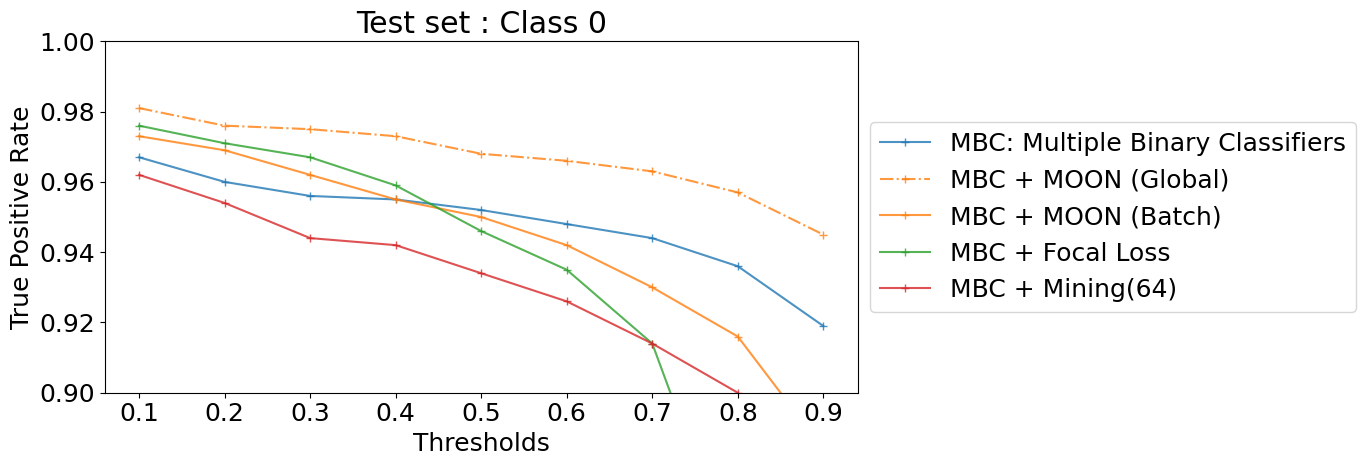

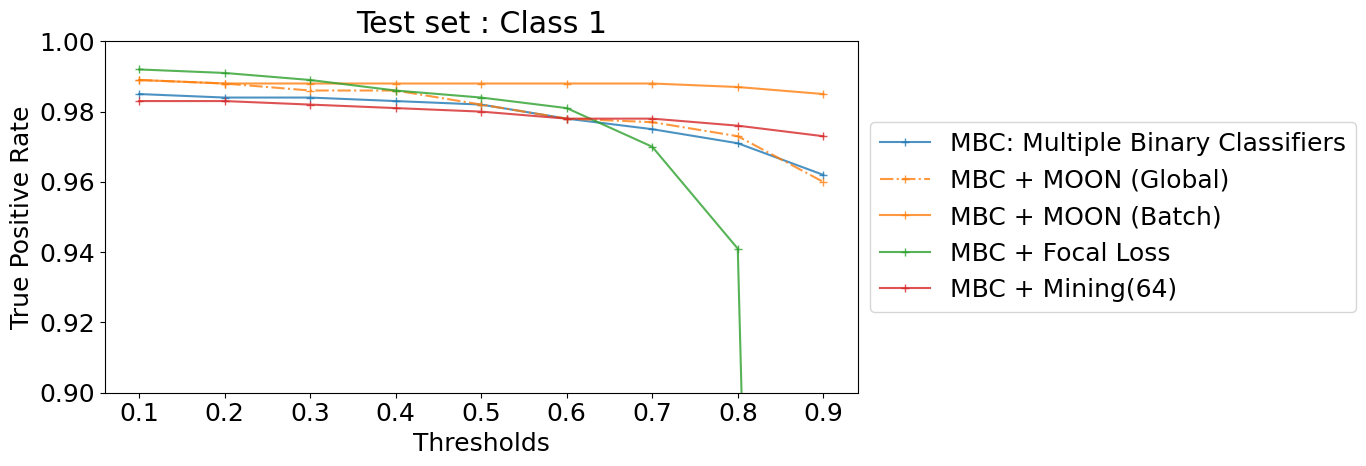

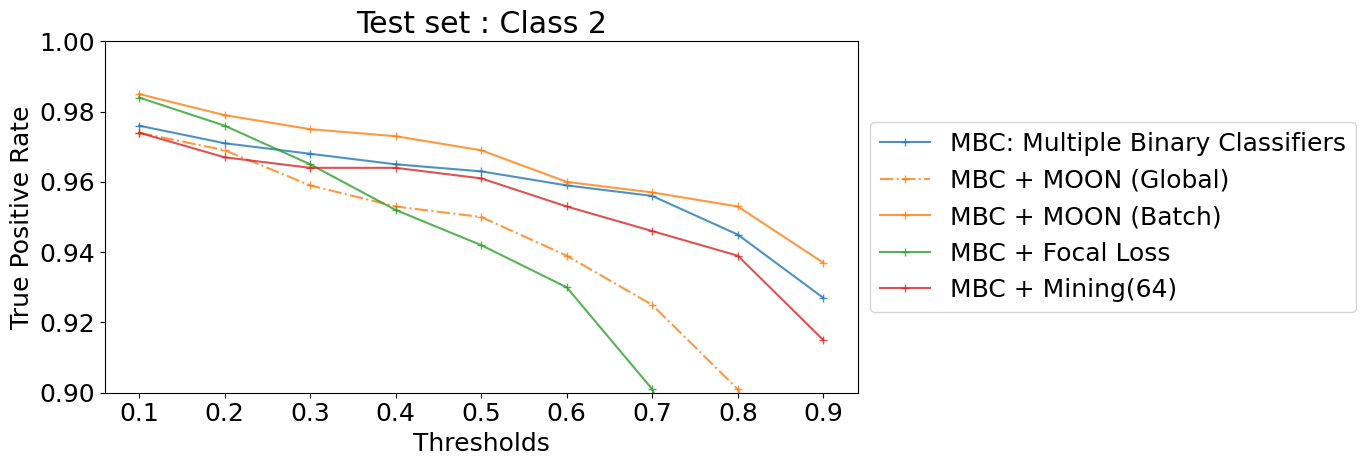

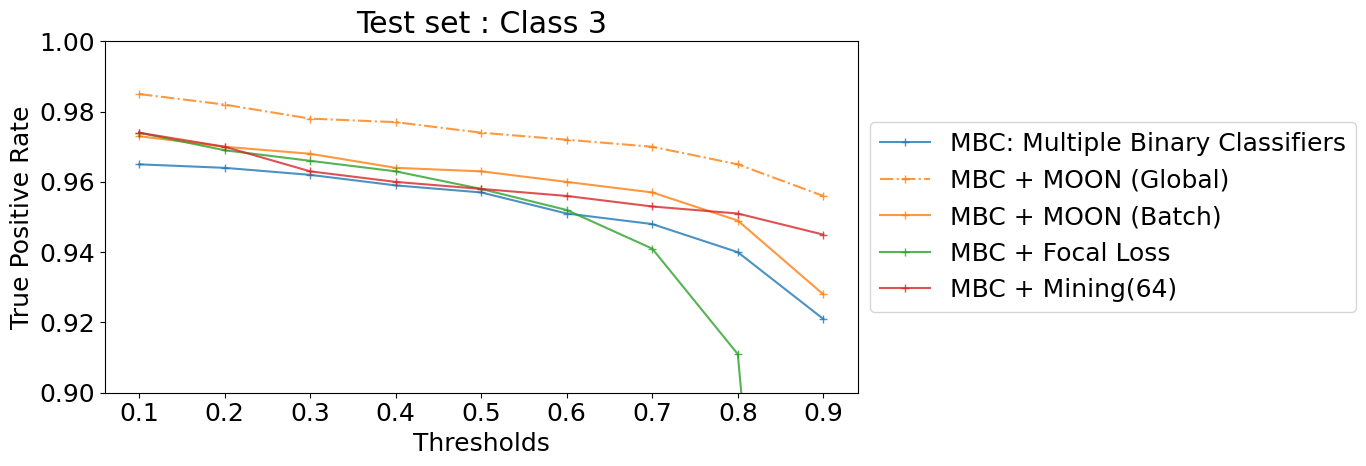

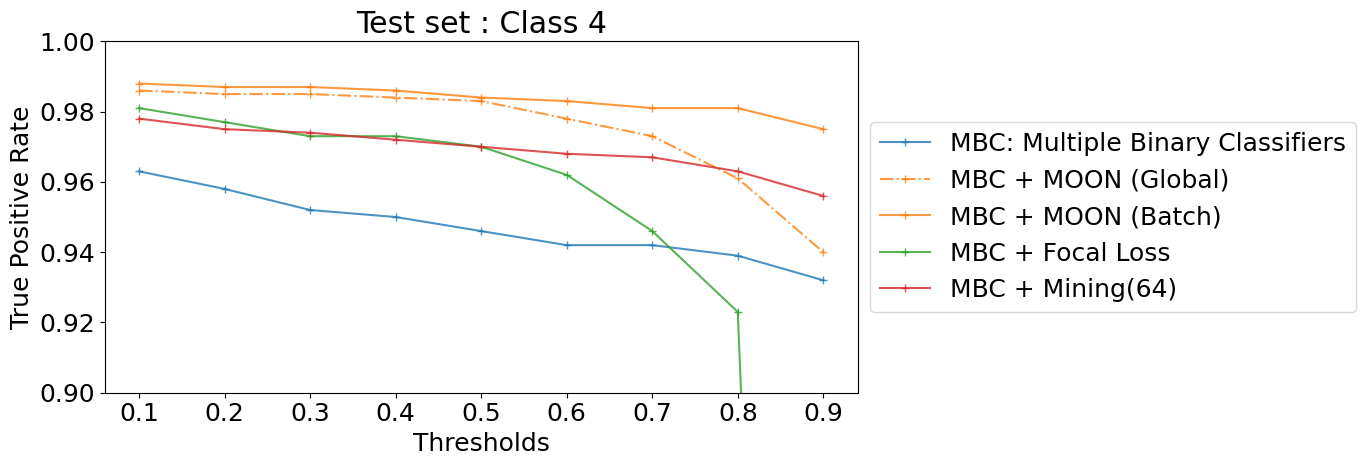

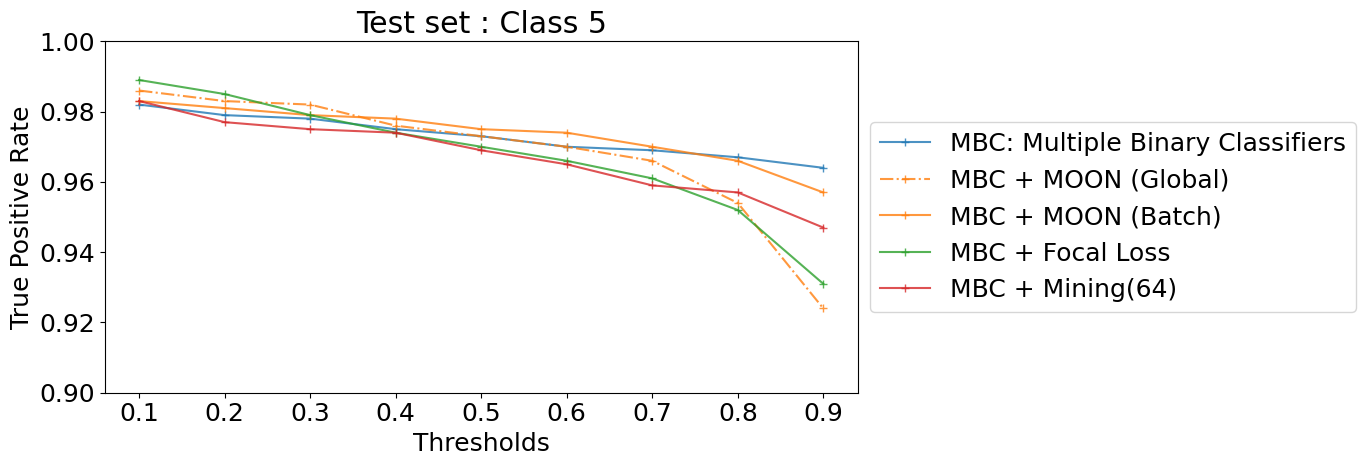

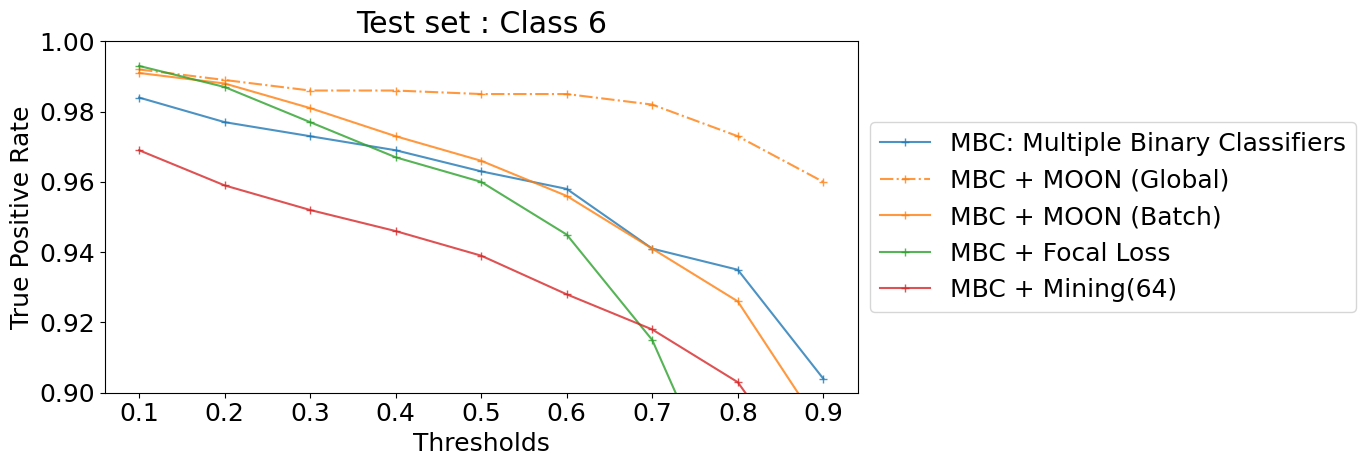

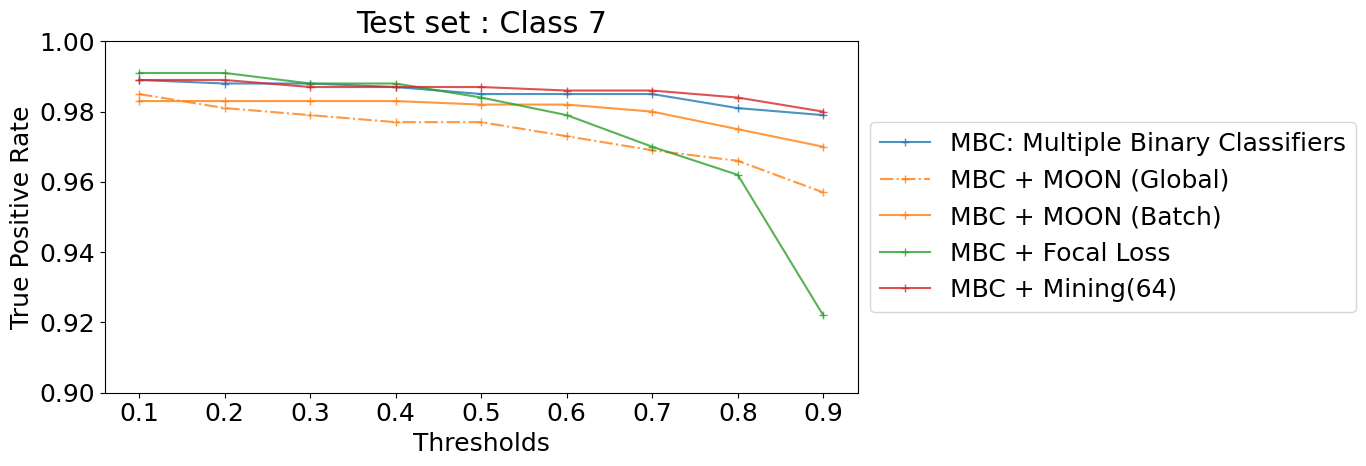

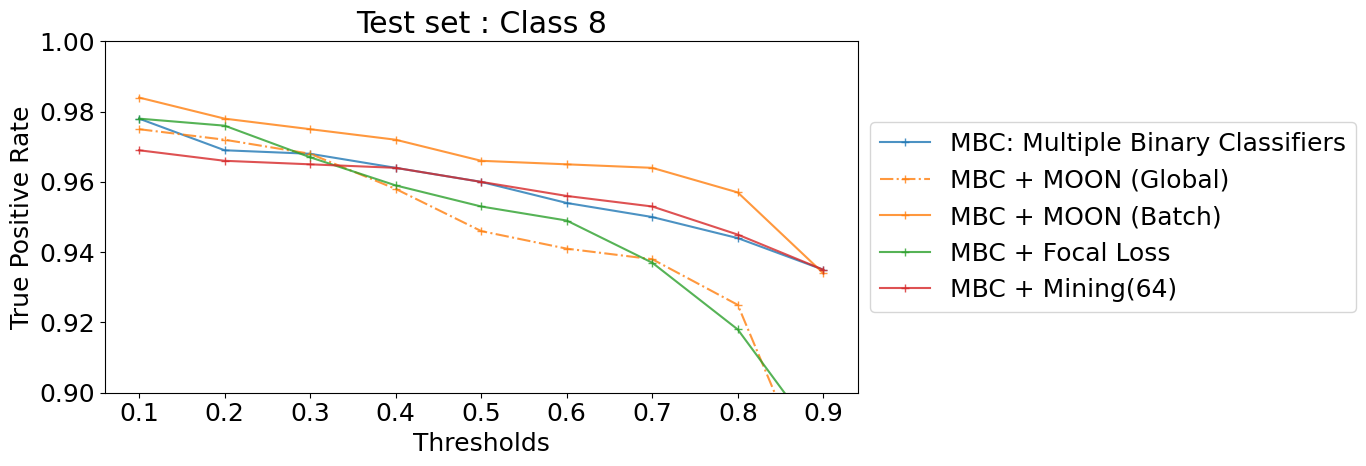

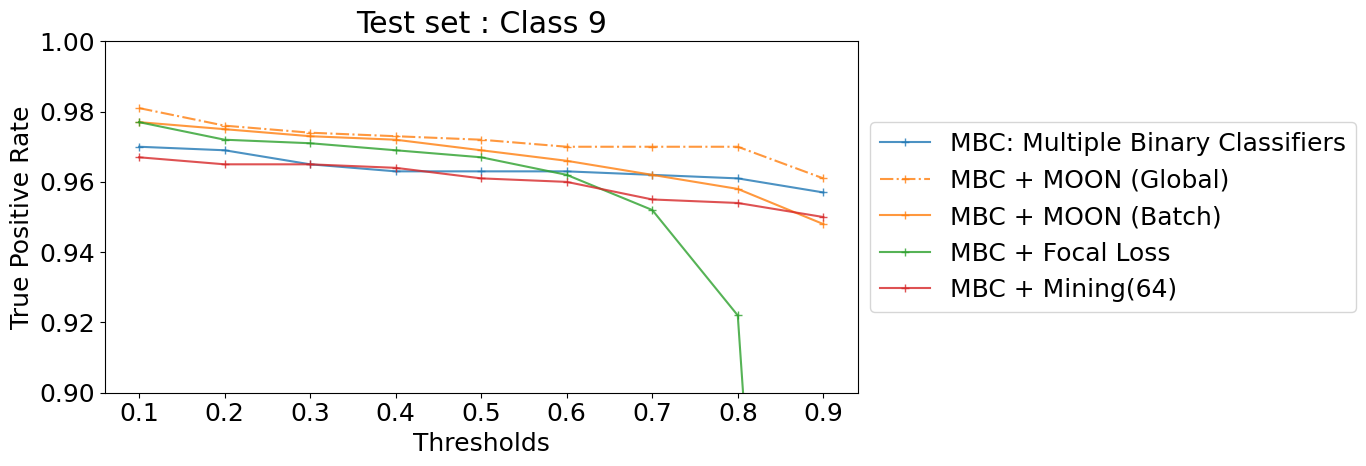

In [35]:
with open('__tpr.txt', 'w') as file:
    for c in classes:
        file.write(f"Class {c}\n")
        pyplot.figure(figsize=(14,5))
        for data in data_infos:
            fpr, tpr, thrs = data['result']
            l, = pyplot.plot(thrs[c], tpr[c], label=data['label'], alpha=data['alpha'], linestyle=data['linestyle'], color = data['color'], marker='+')
            file.write('\t'.join([str(v) for v in tpr[c]]) + '\n')
        pyplot.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        pyplot.xlabel("Thresholds")
        pyplot.ylim(0.9,1)
        pyplot.ylabel("True Positive Rate")
        pyplot.title(f"Test set : Class {c}")
        pyplot.tight_layout()
        pyplot.savefig(f'{c}_tpr.png')

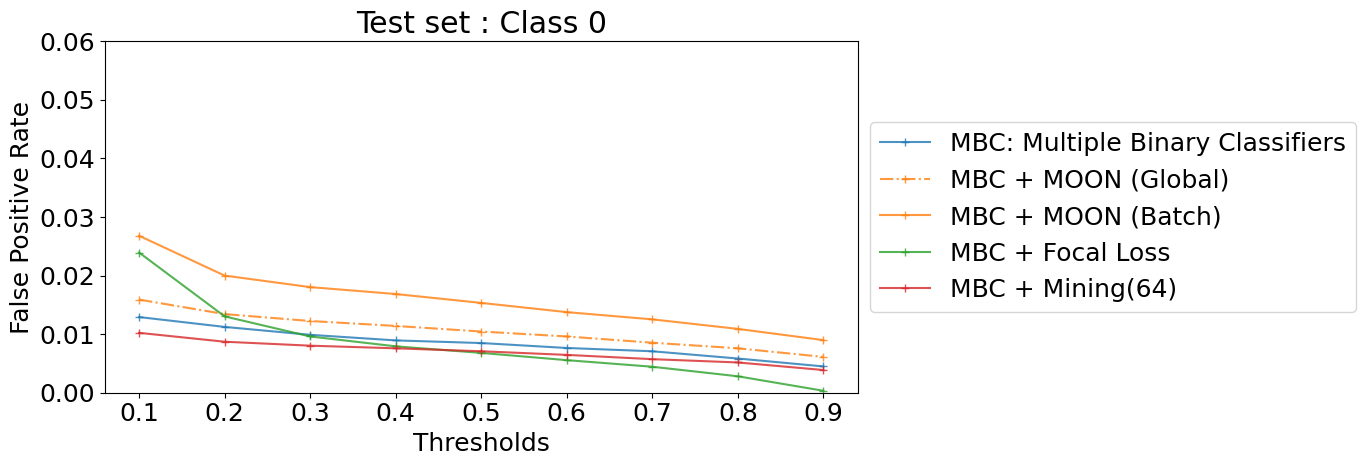

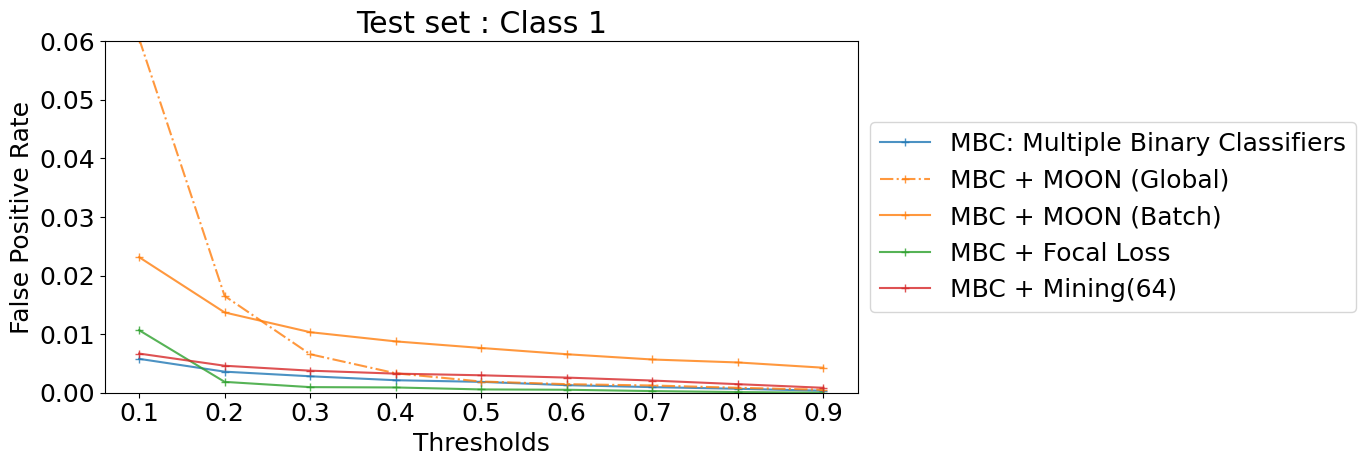

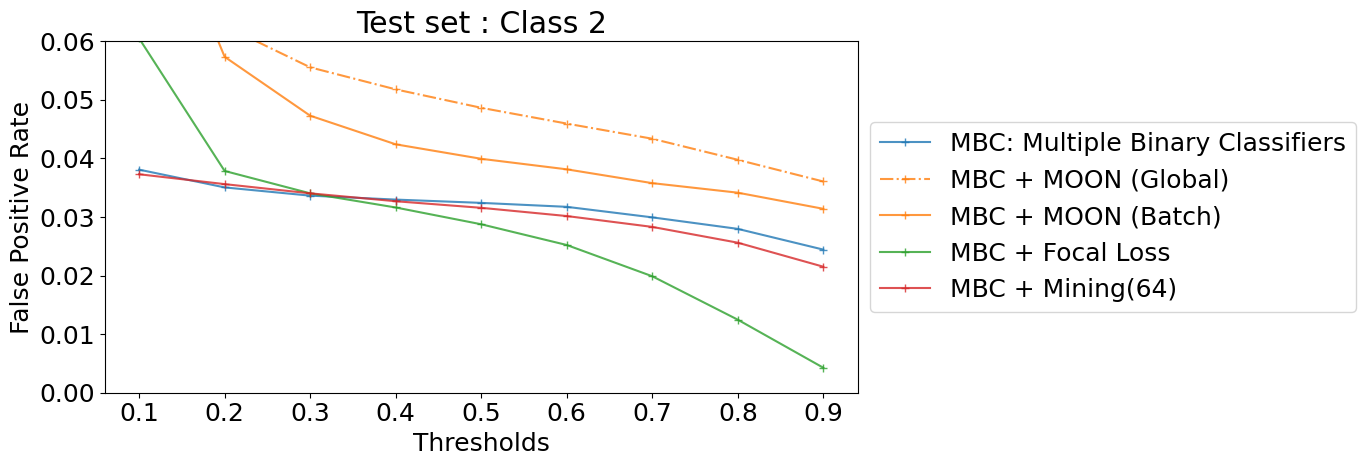

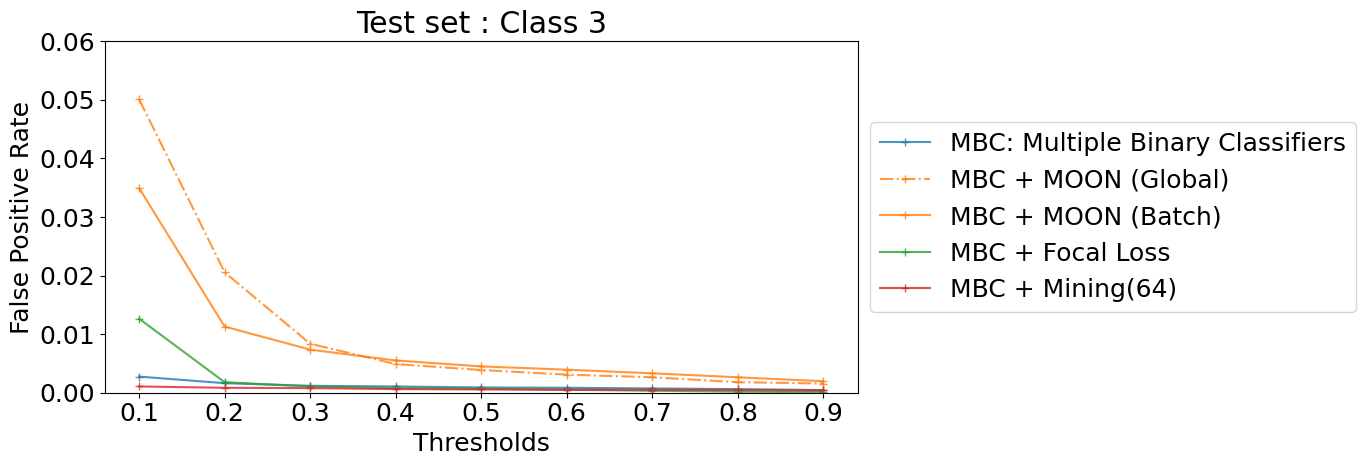

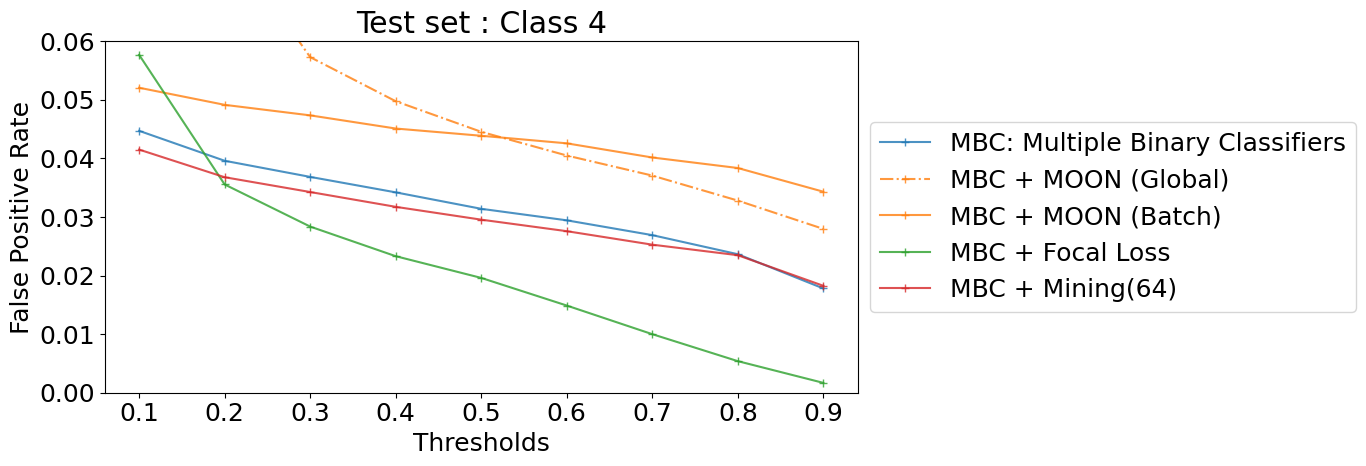

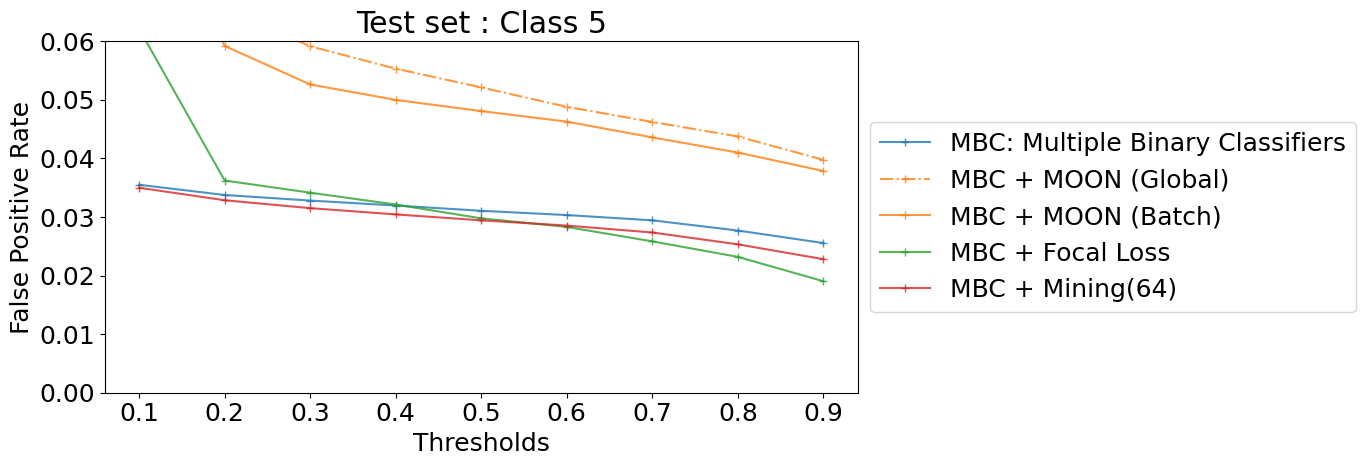

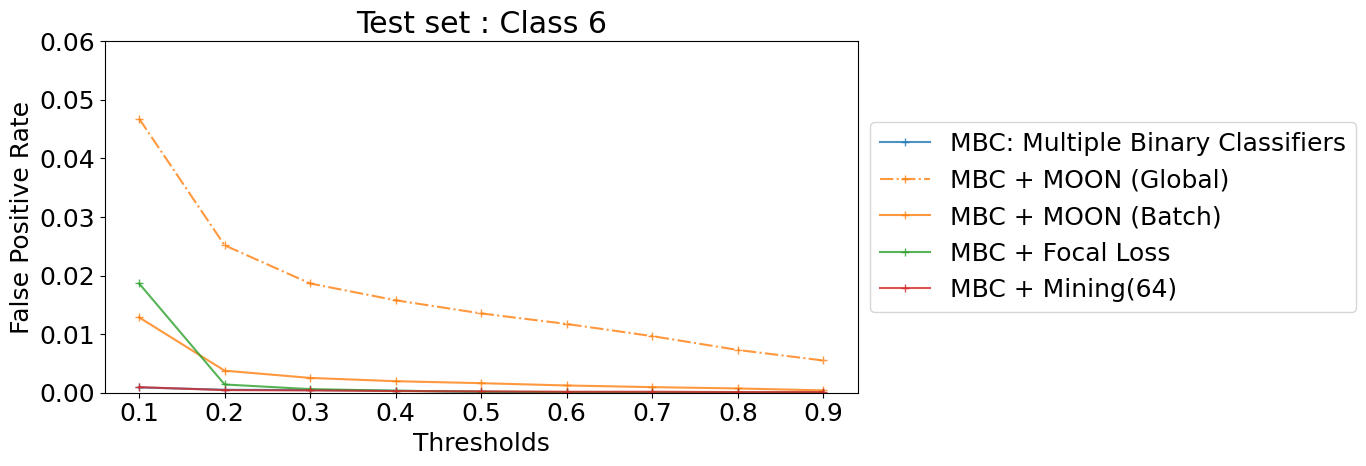

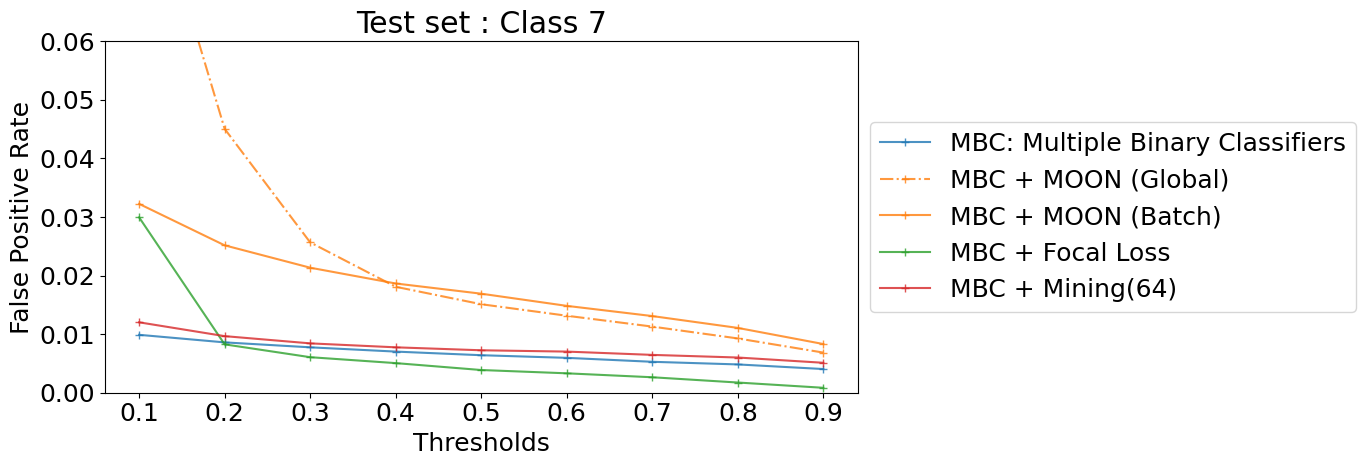

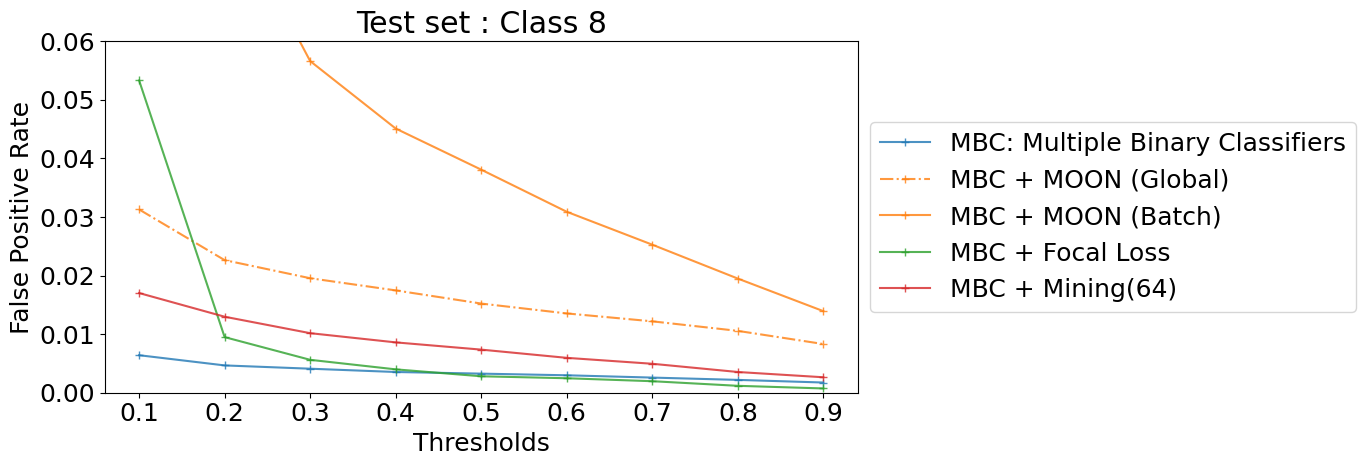

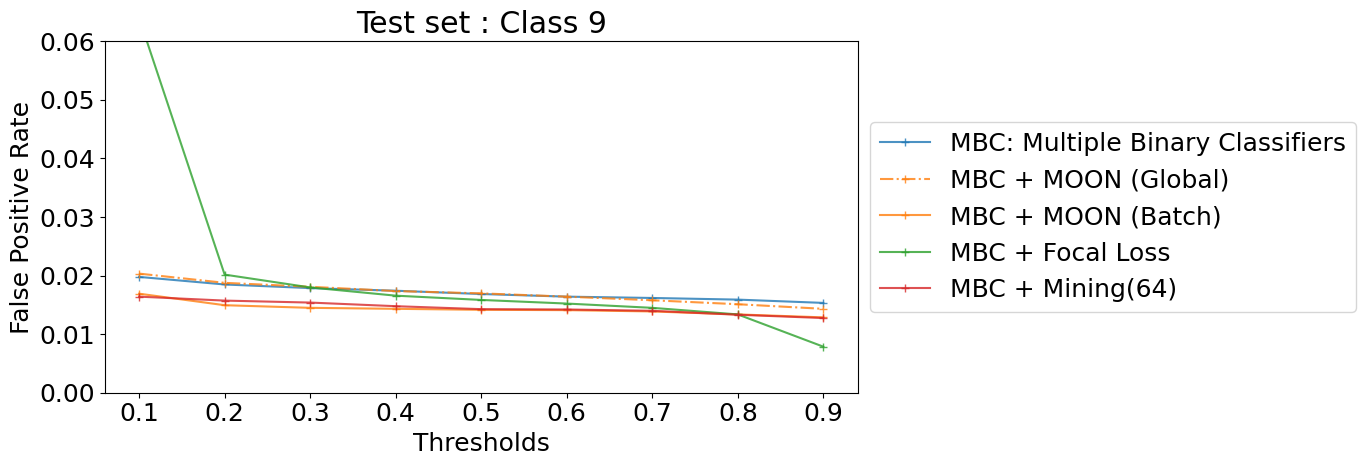

In [37]:
with open('__fpr.txt', 'w') as file:
    for c in classes:
        file.write(f"Class {c}\n")
        pyplot.figure(figsize=(14,5))
        for data in data_infos:
            fpr, tpr, thrs = data['result']
            l, = pyplot.plot(thrs[c], fpr[c], label=data['label'], alpha=data['alpha'], linestyle=data['linestyle'], color = data['color'], marker='+')
            file.write('\t'.join([str(v) for v in fpr[c]]) + '\n')
        pyplot.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        pyplot.xlabel("Thresholds")
        pyplot.ylim(0,0.06)
        pyplot.ylabel("False Positive Rate")
        pyplot.title(f"Test set : Class {c}")
        pyplot.tight_layout()
        pyplot.savefig(f'{c}_fpr.png')